In this notebook, we're going to talk about the importance of the spacing between data points in a time series and how to adjust that spacing post-hoc in software.


# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install ipywidgets
!pip install os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
!wget -Ncnp https://physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv

--2024-06-13 00:22:00--  https://physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25931775 (25M) [text/plain]
Saving to: ‘id00b70b13.csv’

id00b70b13.csv      100%[===================>]  24.73M   291KB/s    in 85s     

2024-06-13 00:23:25 (300 KB/s) - ‘id00b70b13.csv’ saved [25931775/25931775]



In [3]:
df = pd.read_csv('id00b70b13.csv')

# Filter to only walking activity, which is given a code of 1
df = df[df['activity'] == 1]

# Process the time
df.rename(columns={'time_s': 'Time'}, inplace=True)
df = df[(df['Time']>=700) & (df['Time']<=710)]
df['Time'] = df['Time'] - df['Time'].min()

# Process the accel
df['Accel'] = np.sqrt(df['la_x']**2 + df['la_y']**2 + df['la_z']**2)*9.8

# Keep only crucial columns
keep_cols = ['Time', 'Accel']
df = df[keep_cols]
df.to_csv('walking.csv',index=False)

# What Is Sampling Rate?

Most phonemona that we would want to represent using time-series data is inherently continuous, but capturing that information into a digital signal that can be processed requires taking mesaurements at discrete time points.

For example, there are two ways that we could record the outdoor air temperature throughout the day: (1) we could periodically look at a thermometer and write down the readings or, (2) we could program a temperature sensor to periodically detect, transmit, and store the sensed temperature. If we were to take the manual approach, we may be able to take a measurement once every five minutes. If we were to take the sensor-based approach, we could go as high as hundreds of measurements per second. Regardless, there is no way of feasibly recording the infite amount of temperatures that theoretically exist.

The ***sampling rate*** is the frequency at which a continuous signal is sampled or measured in order to convert it into a digital signal. The units that we typical use to discuss sampling rate is samples per second, also known as Hertz (Hz).

The sampling rate determines the level of detail and accuracy of the digital representation of the original signal. A higher sampling rate results in a more accurate representation of the original signal, but it also requires more storage and computational power to process.

To understand the implications of a sampling rate, let's digitally sample a signal that we will pretend to be a continuous sinusoid.

In the code cell below, the black line represents the continuous signal, while the red points indicate the digital samples that are recorded according to the sampling rate. Bear in mind that the red lines are strictly used to show the shape of the data being summarized. In actuality, the only information that is being saved is the red circles.

Look at the impact of increasing and decreasing the sampling rate by moving the `sampling_rate` slider and then re-running the code block.

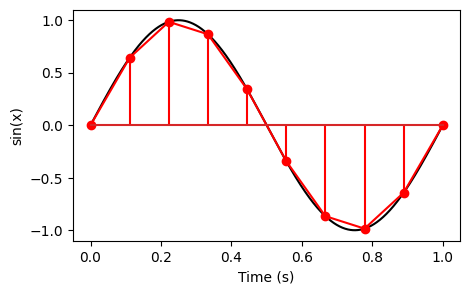

In [4]:
sampling_rate = 10 #@param {type:"slider", min:5, max:25, step:5}

# Calculate the "real signal"
x = np.linspace(0, 1, 1000)
y = np.sin(2*np.pi*x)

# Calculate the "sampled signal"
x_sampled = np.linspace(0, 1, sampling_rate)
y_sampled = np.sin(2*np.pi*x_sampled)

# Plot both of them
plt.figure(figsize=(5, 3))
plt.plot(x, y, 'k-')
plt.plot(x_sampled, y_sampled, 'r-')
plt.stem(x_sampled, y_sampled, 'r')
plt.xlabel('Time (s)')
plt.ylabel('sin(x)')
plt.show()

When our sampling rate is very low, the sampled points do not sufficiently summarize the shape of the smooth curvy signal. As we increase the sampling rate, the lines drawn between the points look closer to our ideal sinuosoid.

# Changing the Sampling Rate

Depending on the signal you are capturing, you may or may not have control over how the data is sampled before you load it in your code. Here are some scenarios where you may have control over the sampling rate of your data:
* You are using a medical device or sensor that allows you to change the setting of how often it produces a measurement
* You have a separate program that periodically queries an API for data (e.g., weather forecasts)
* You are asking people to fill out a questionnaire or survey at a fixed interval

You might find yourself in situations when you will want to digitally change the sampling rate of your data to simplify your analysis:
1. You might want to **upsample**, or increase the sampling rate of your signal, to fill in gaps or provide more fidelity for downstream analysis.
2. You might want to **downsample**, or decrease the sampling rate of your signal, to speed up your code by reducing the amount of data you need to process.
3. You might want to make the sampling **more uniform** because it was not collected at a regular interval.

One way we can modify the sampling rate of our data is by using ***interpolation***. Interpolation refers to the idea of estimating values that lie between two known data points. There are multiple variations of interpolation; some examples are described below in increasing order of complexity:
* **Nearest neighbor interpolation:** Missing values are assigned based on the closest data point from the original signal.
* **Linear interpolation:** Missing values are assigned based on a line that is drawn between the two closest data points from the original signal.
* **Spline interpolation:** Missing values are assigned based on piecewise polynomial functions fit to sections of the original signal.

We will cover three of the many ways that we can change how data is sampled: one manual approach, a second with `pandas`, and a third with `numpy`.

## Option 1: Manual Downsampling

If we need to downsample a signal that already has even spacing between time points, all we need to do is slice the data such that we only collect time points at indices spaced apart according to the new sampling rate. For example, if we want to downsample a 20 Hz signal to a 10 Hz signal, we can simply throw away every other data point.

The code cell below illustrates how this is done. The time series in black represents our initial signal, which is sampled at 20 Hz. The variable `new_sampling_rate` will dictate how many points we want in the new time series between the start and end of the original signal.

Play around with different settings of `new_sampling_rate` to see what happens. Notice that when we calculate `downsampling_interval`, we use the `int()` function to ensure that the indices we calculate are whole numbers. In other words, this method is best suited when the new sampling rate is an integer factor of the original sampling rate. If you pick a new sampling rate that is not an integer factor, rounding errors will lead you to a different sampling rate.

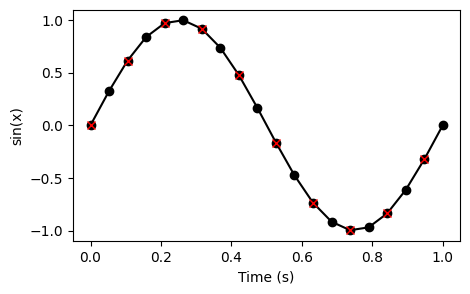

In [ ]:
new_sampling_rate = 10 #@param {type:"slider", min:5, max:20, step:5}

# Computing the downsample rate
old_sampling_rate = 20
downsampling_increment = int(old_sampling_rate/new_sampling_rate)

# Generate the original signal
x = np.linspace(0, 1, old_sampling_rate)
y = np.sin(2*np.pi*x)

# Calculate where the new points should be
idxs = range(0, len(x), downsampling_increment)

# Use the indicies to select the new data points
x_resampled = x[idxs]
y_resampled = y[idxs]

# Plot both of them
plt.figure(figsize=(5, 3))
plt.plot(x, y, 'k-o')
plt.plot(x_resampled, y_resampled, 'rx')
plt.xlabel('Time (s)')
plt.ylabel('sin(x)')
plt.show()

## Option 2: Resampling with `pandas`

`pandas` provides some functions to help you change the sampling rate of your data provided that you have represented the time of each data point using a `Timestamp` object. One example involves the `resample()` method, which works on `Series` that have a `datetime`-like index.

To illustrate how this work, let's generate a `Series` in which we have a number that gets recorded after each minute for 10 minutes:

In [5]:
num_minutes = 10
index = pd.date_range('1/1/2000', periods=num_minutes, freq='T')
series = pd.Series(range(num_minutes), index=index)
series.head(num_minutes)

2000-01-01 00:00:00    0
2000-01-01 00:01:00    1
2000-01-01 00:02:00    2
2000-01-01 00:03:00    3
2000-01-01 00:04:00    4
2000-01-01 00:05:00    5
2000-01-01 00:06:00    6
2000-01-01 00:07:00    7
2000-01-01 00:08:00    8
2000-01-01 00:09:00    9
Freq: T, dtype: int64

The `resample()` method returns a special `Resampler` object specifically designed to group `Series` elements based on time. For the sake of upsampling, we don't want anything to be grouped, so we can use the `asfreq()` method to give us a new `DataFrame` that is reindexed according to our target frequency.

In the example below, we have reindexed our `DataFrame` such that there is a row for every 30 seconds:

In [6]:
series.resample('30S').asfreq()

2000-01-01 00:00:00    0.0
2000-01-01 00:00:30    NaN
2000-01-01 00:01:00    1.0
2000-01-01 00:01:30    NaN
2000-01-01 00:02:00    2.0
2000-01-01 00:02:30    NaN
2000-01-01 00:03:00    3.0
2000-01-01 00:03:30    NaN
2000-01-01 00:04:00    4.0
2000-01-01 00:04:30    NaN
2000-01-01 00:05:00    5.0
2000-01-01 00:05:30    NaN
2000-01-01 00:06:00    6.0
2000-01-01 00:06:30    NaN
2000-01-01 00:07:00    7.0
2000-01-01 00:07:30    NaN
2000-01-01 00:08:00    8.0
2000-01-01 00:08:30    NaN
2000-01-01 00:09:00    9.0
Freq: 30S, dtype: float64

All that this does is reindex our `DataFrame`; neither the `resample()` method nor the `asfreq()` method are designed to fill in the values of the missing rows. However, we can use methods like `ffill()` and `bfill()` to forward-fill and back-fill the missing entries, respectively.

In [7]:
# Forward fill
series.resample('30S').ffill()

2000-01-01 00:00:00    0
2000-01-01 00:00:30    0
2000-01-01 00:01:00    1
2000-01-01 00:01:30    1
2000-01-01 00:02:00    2
2000-01-01 00:02:30    2
2000-01-01 00:03:00    3
2000-01-01 00:03:30    3
2000-01-01 00:04:00    4
2000-01-01 00:04:30    4
2000-01-01 00:05:00    5
2000-01-01 00:05:30    5
2000-01-01 00:06:00    6
2000-01-01 00:06:30    6
2000-01-01 00:07:00    7
2000-01-01 00:07:30    7
2000-01-01 00:08:00    8
2000-01-01 00:08:30    8
2000-01-01 00:09:00    9
Freq: 30S, dtype: int64

In [8]:
# Backward fill
series.resample('30S').bfill()

2000-01-01 00:00:00    0
2000-01-01 00:00:30    1
2000-01-01 00:01:00    1
2000-01-01 00:01:30    2
2000-01-01 00:02:00    2
2000-01-01 00:02:30    3
2000-01-01 00:03:00    3
2000-01-01 00:03:30    4
2000-01-01 00:04:00    4
2000-01-01 00:04:30    5
2000-01-01 00:05:00    5
2000-01-01 00:05:30    6
2000-01-01 00:06:00    6
2000-01-01 00:06:30    7
2000-01-01 00:07:00    7
2000-01-01 00:07:30    8
2000-01-01 00:08:00    8
2000-01-01 00:08:30    9
2000-01-01 00:09:00    9
Freq: 30S, dtype: int64

## Option 3: Interpolation with `numpy`

The `interp()` function in `numpy` is one of the convenient ways of performing linear interpolation. This function requires three inputs:
1. The times at which the new samples should be generated
2. The times of the original samples
3. The values of the original samples

The code cell below illustrates the output of this function. The time series in black represents our initial signal, which is sampled at 20 Hz. The variable `new_sampling_rate` will dictate how many points we want in the new time series between the start and end of the original signal.

Play around with different settings of `new_sampling_rate` to see what happens. As you can tell by the range of the slider, you can actually use this function to upsample or downsample the signal.

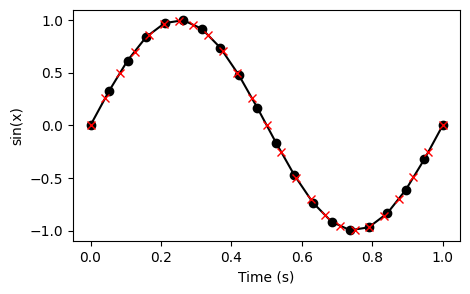

In [9]:
new_sampling_rate = 25 #@param {type:"slider", min:5, max:35, step:5}

# Generate the original signal
x = np.linspace(0, 1, 20)
y = np.sin(2*np.pi*x)

# Calculate where the new points should be
x_resampled = np.linspace(0, 1, new_sampling_rate)

# Use the interp function to calculate where the new y-values should be
y_resampled = np.interp(x_resampled, x, y)

# Plot both of them
plt.figure(figsize=(5, 3))
plt.plot(x, y, 'k-o')
plt.plot(x_resampled, y_resampled, 'rx')
plt.xlabel('Time (s)')
plt.ylabel('sin(x)')
plt.show()

This technique can also work in situations when data is missing, but bear in mind that interpolation can only generate data using information that is already available in the original signal.

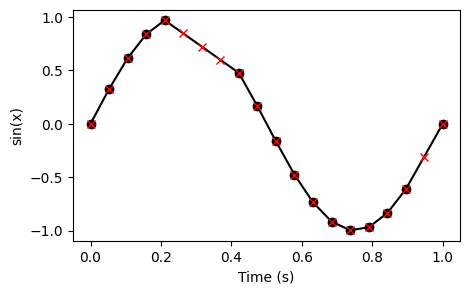

In [10]:
# Generate the original signal
x = np.linspace(0, 1, 20)
y = np.sin(2*np.pi*x)

# Remove some data points
remove_idx = [5, 6, 7, 18]
x = np.delete(x, remove_idx)
y = np.delete(y, remove_idx)

# Calculate where the new points should be
x_resampled = np.linspace(0, 1, 20)

# Use the interp function to calculate where the new y-values should be
y_resampled = np.interp(x_resampled, x, y)

# Plot both of them
plt.figure(figsize=(5, 3))
plt.plot(x, y, 'k-o')
plt.plot(x_resampled, y_resampled, 'rx')
plt.xlabel('Time (s)')
plt.ylabel('sin(x)')
plt.show()